In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
import matplotlib.backends.backend_pdf

sns.set_theme(color_codes=True)
sys.path.insert(0, ".././0.data-download/scripts/")

from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

import blitzgsea as blitz
import urllib.request

# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


2023-06-20 16:32:16.801804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - Kinase_Perturbations_from_GEO_down
16 - Disease_Signatures_from_GEO_down_2014
17 - Disease_Perturbations_from_GEO_up
18 - Old_CMAP_down
19 - MCF7_Perturbations_from_GEO_up
20 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
21 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
22 - PPI_Hub_Proteins
23 - Disease_Signatures_from_GEO_up_2014
24 - GTEx_Tissue_Expression_Up
25 - L1000_Kinase_and_GPCR_Perturbati

In [4]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("GO_Biological_Process_2017")

In [5]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE/results/weight_matrix_gsea.csv")
signature = pd.read_csv(gene_weight_dir)
print(signature.shape)
signature.head()

(1000, 71)


,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,FAM50A,-0.065517,-0.032733,0.016796,-0.054844,0.036953,-0.050535,0.035076,0.007159,0.032103,...,0.067391,-0.024657,-0.012545,0.004022,0.009111,0.007209,0.038655,0.041393,-0.013804,0.034198
1,CDK6,-0.002679,0.045508,0.031917,0.006865,-0.011732,-0.044319,-0.001106,-0.030111,-0.032521,...,-0.003756,-0.098214,-0.030270,0.029220,0.024960,-0.031610,-0.077953,-0.005751,-0.028775,-0.027772
2,CDAN1,-0.065351,-0.022536,0.002443,0.003644,-0.052182,0.003413,0.043525,-0.001345,0.041294,...,0.052262,-0.020468,-0.038528,0.019662,0.013879,-0.020691,0.019237,0.010507,-0.010602,0.025415
3,GPX4,-0.051662,-0.011450,-0.063152,0.023219,0.004973,0.056593,0.018017,-0.054374,-0.011835,...,0.005306,-0.060739,-0.045656,-0.001605,-0.040403,-0.023258,-0.043615,-0.081619,-0.029048,-0.069127
4,SEPHS2,-0.013521,-0.010980,-0.004323,0.046486,-0.047013,0.034360,-0.049736,0.044843,-0.027027,...,-0.012993,-0.016999,-0.053929,0.027880,0.047067,0.017589,-0.057068,-0.060426,-0.073335,-0.057183


In [6]:
# Running GSEA

all_GSEA_results = []
all_signatures = []
results = []

range = signature.shape[1]

for col in signature.iloc[:,1:range].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library)
    results.append(result)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)

In [7]:
# Copying signature dataframe without gene column
neg_signature = signature.iloc[:, 1:].copy()

# Vertically shuffling the data in each column to create a negative control
for col in neg_signature.columns:
    neg_signature.loc[:, col] = np.random.permutation(neg_signature.loc[:, col].values)

# Adding gene column back to finalize negative control data
genes = signature.iloc[:,:1]
neg_signature.insert(0,'0', genes)

# Running GSEA with negative control data
neg_GSEA_results = []
negative_control = []

range = neg_signature.shape[1]

for col in neg_signature.iloc[:,1:range].columns:
    neg_df = neg_signature.iloc[:,[0,int(col)]]
    neg_result = blitz.gsea(neg_df, library)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

In [8]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

# merging real and negative control gsea results to single dataframe with column specifying source
all_GSEA_results['source'] = 'real'
neg_GSEA_results['source'] = 'negative control'

combo_gsea_df = pd.concat([all_GSEA_results, neg_GSEA_results])

# saving gsea results as single output file
combo_gsea_dir = pathlib.Path("./results/combined_gsea_results.csv.gz")
combo_gsea_df.to_csv(combo_gsea_dir, compression = 'gzip')


In [9]:
# sort by what you want to evaluate
combo_gsea_df.sort_values(by='nes', ascending = True)

,es,nes,pval,sidak,fdr,geneset_size,leading_edge,z_dim,source
Term,,,,,,,,,
mitochondrial translational termination (GO:0070126),-0.376526,-8.221582,2.008364e-16,4.980743e-14,4.980743e-14,67,"MRPS7,MRPS17,MRPL39,MRPL21,MRPS30,MRPL47,MRPL5...",z_66,real
mitochondrial translational elongation (GO:0070125),-0.368690,-8.059022,7.690717e-16,1.907298e-13,9.536489e-14,67,"MRPS7,MRPS17,MRPL39,MRPL21,MRPS30,MRPL47,MRPL5...",z_66,real
mitochondrial translational elongation (GO:0070125),-0.348022,-7.537976,4.773216e-14,1.183758e-11,9.175957e-12,67,"MRPL43,MRPS7,ERAL1,MRPS18B,GADD45GIP1,MRPL32,M...",z_48,real
mitochondrial translational termination (GO:0070126),-0.345399,-7.480572,7.399966e-14,1.835191e-11,9.175957e-12,67,"MRPL43,MRPS7,ERAL1,MRPS18B,GADD45GIP1,MRPL32,M...",z_48,real
mitochondrial translational elongation (GO:0070125),-0.380745,-6.392622,1.630647e-10,4.044005e-08,4.044005e-08,67,"MRPL16,MRPL22,MRPL47,MRPL48,MRPS26,MRPL2,MRPS1...",z_16,real
...,...,...,...,...,...,...,...,...,...
mitochondrial translational termination (GO:0070126),0.381896,6.487757,8.712360e-11,2.160665e-08,2.160665e-08,67,"MRPS14,ERAL1,MRPL14,MRPL53,MRPL54,MRPL2,MRPL41...",z_18,real
mitochondrial translational elongation (GO:0070125),0.512386,inf,2.633298e-17,6.530578e-15,6.530578e-15,67,"MRPL57,MRPL49,MRPL38,MRPS16,MRPL41,MRPL37,MRPS...",z_3,real
mitochondrial translational termination (GO:0070126),0.502707,inf,9.602703e-17,2.381470e-14,1.190735e-14,67,"MRPL57,MRPL49,MRPL38,MRPS16,MRPL41,MRPL37,MRPS...",z_3,real


Text(0.5, 1.0, 'Control Gene Set Enrichment Analysis')

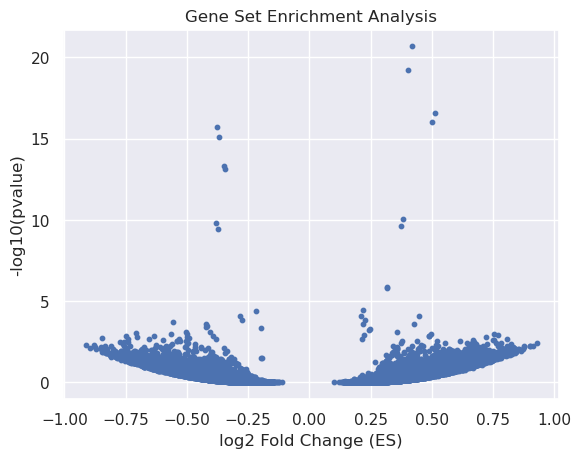

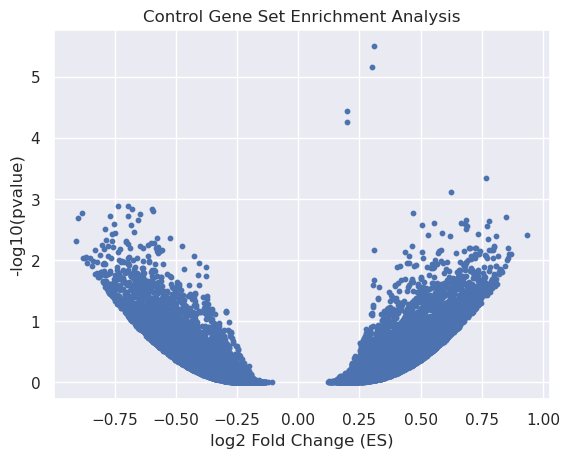

In [10]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

In [11]:
# Using VAE generated data

pdf_path = pathlib.Path("../1.data-exploration/figures/gsea_plots.pdf")
pdf = matplotlib.backends.backend_pdf.PdfPages(pdf_path)

# Looping over each dataframe in all_signatures to generate gsea plots for the chosen geneset with data 
# from each latent dimension (1-100) and saving the plots to a singular pdf
for df in all_signatures:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "mitochondrial translational elongation (GO:0070125)"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=False)
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()


    fig_compact = blitz.plot.running_sum(df, geneset, library, result=z_result, compact=True)
    pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

pdf.close()


# Using negative control

ctrl_pdf_path = pathlib.Path("../1.data-exploration/figures/ctrl_gsea_plots.pdf")
ctrl_pdf = matplotlib.backends.backend_pdf.PdfPages(ctrl_pdf_path)

# Looping over each dataframe in negative_control to generate gsea plots for the chosen geneset with data 
# from each latent dimension (1-100) and saving the plots to a singular pdf
for df in negative_control:
    col_titles = df.columns.tolist()
    dim = col_titles[1]
    z_result = results[int(dim)-1]

    geneset = "mitochondrial translational elongation (GO:0070125)"

    text, ax = plt.subplots()
    ax.text(0.5, 0.5, 'The three following figures visualize the negative control gene set enrichment analysis results for ' + geneset + ' in the latent dimension z=' + dim, fontsize=16, ha='center')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ctrl_pdf.savefig(text, bbox_inches='tight')
    plt.close()

    fig = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=False)
    ctrl_pdf.savefig(fig, bbox_inches='tight')
    plt.close()

    fig_compact = blitz.plot.running_sum(df, "mitochondrial translational elongation (GO:0070125)", library, result=z_result, compact=True)
    ctrl_pdf.savefig(fig_compact, bbox_inches='tight')
    plt.close()

    fig_table = blitz.plot.top_table(df, library, z_result, n=15)
    ctrl_pdf.savefig(fig_table, bbox_inches='tight')
    plt.close()

ctrl_pdf.close()